In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy as sp
import random
import warnings
import string
import imutils
import datetime
warnings.filterwarnings("ignore")
%matplotlib inline

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
# Load the data A.S
train_name = pd.read_csv('D:/WorkStation/Datasets/archive/written_name_train_v2.csv')
test_name = pd.read_csv('D:/WorkStation/Datasets/archive/written_name_test_v2.csv')
val_name = pd.read_csv('D:/WorkStation/Datasets/archive/written_name_validation_v2.csv')

In [3]:
train_name.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


In [4]:
train_name.describe()

,FILENAME,IDENTITY
count,330961,330396
unique,330961,100539
top,TRAIN_00001.jpg,THOMAS
freq,1,1825


In [5]:
test_name.describe()

,FILENAME,IDENTITY
count,41370,41300
unique,41370,20279
top,TEST_0001.jpg,THOMAS
freq,1,227


In [6]:
train_name.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330961 entries, 0 to 330960
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   FILENAME  330961 non-null  object
 1   IDENTITY  330396 non-null  object
dtypes: object(2)
memory usage: 5.1+ MB


In [7]:
test_name.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41370 entries, 0 to 41369
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   FILENAME  41370 non-null  object
 1   IDENTITY  41300 non-null  object
dtypes: object(2)
memory usage: 646.5+ KB


In [8]:
train_name.shape

(330961, 2)

In [9]:
test_name.shape

(41370, 2)

In [10]:
val_name.shape

(41370, 2)

In [11]:
train_name.dtypes

FILENAME    object
IDENTITY    object
dtype: object

In [12]:
train_name.columns

Index(['FILENAME', 'IDENTITY'], dtype='object')

D:/WorkStation/Datasets/archive/train_v2/train/TRAIN_00001.jpg
D:/WorkStation/Datasets/archive/train_v2/train/TRAIN_00002.jpg
D:/WorkStation/Datasets/archive/train_v2/train/TRAIN_00003.jpg
D:/WorkStation/Datasets/archive/train_v2/train/TRAIN_00004.jpg
D:/WorkStation/Datasets/archive/train_v2/train/TRAIN_00005.jpg
D:/WorkStation/Datasets/archive/train_v2/train/TRAIN_00006.jpg


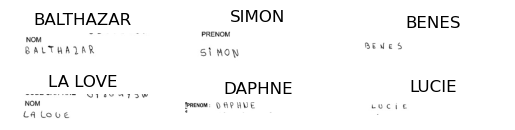

In [13]:
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'D:/WorkStation/Datasets/archive/train_v2/train/'+train_name.loc[i, 'FILENAME']
    print(img_dir)
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train_name.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [14]:
print("Number of NaNs in the train dataset is: ", train_name['IDENTITY'].isnull().sum())
print("Number of NaNs in the validation dataset is: ", val_name['IDENTITY'].isnull().sum())
print("Number of NaNs in the test dataset is: ", test_name['IDENTITY'].isnull().sum())

Number of NaNs in the train dataset is:  565
Number of NaNs in the validation dataset is:  78
Number of NaNs in the test dataset is:  70


In [15]:
# Drop rows with missing labels A.S
train_name.dropna(axis=0, inplace=True)
val_name.dropna(axis=0, inplace=True)
test_name.dropna(axis=0, inplace=True)

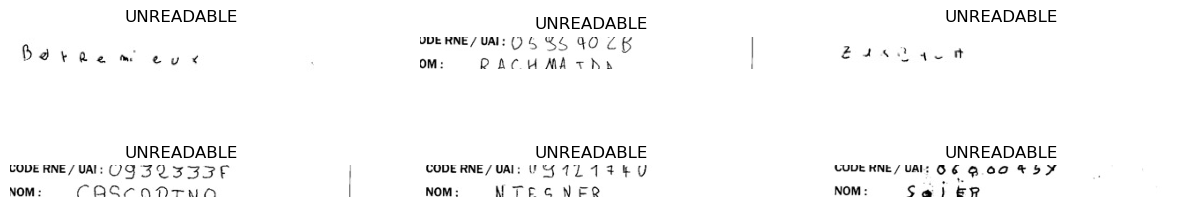

In [16]:
unreadable = train_name[train_name['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop = True)

plt.figure(figsize=(15,10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'D:/WorkStation/Datasets/archive/train_v2/train/'+unreadable.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [17]:
# Remove unreadable images A.S
train_name = train_name[train_name['IDENTITY'] != 'UNREADABLE']
val_name = val_name[val_name['IDENTITY'] != 'UNREADABLE']
test_name = test_name[test_name['IDENTITY'] != 'UNREADABLE']

In [18]:
# Convert labels to uppercase A.S
train_name['IDENTITY'] = train_name['IDENTITY'].str.upper()
val_name['IDENTITY'] = val_name['IDENTITY'].str.upper()
test_name['IDENTITY'] = test_name['IDENTITY'].str.upper()

In [19]:
# Reset the index A.S
train_name.reset_index(inplace = True, drop = True)
val_name.reset_index(inplace = True, drop = True)
test_name.reset_index(inplace = True, drop = True)

In [20]:
def increaseImageQuality(img):
    # Check image type and convert if necessary
    if img.dtype != np.uint8:
        img = np.uint8(img / np.max(img) * 255)
    # Increase the contrast of the image
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)

    # Sharpen the image
    kernel = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])
    img = cv2.filter2D(img, -1, kernel)
    
    return img

In [21]:
def preprocessOutputImage(img):
    (h, w) = img.shape
    
    # Calculate the new size while preserving the aspect ratio
    max_width = 256
    max_height = 64
    aspect_ratio = float(img.shape[1]) / img.shape[0]
    new_width = int(max_height * aspect_ratio)
    new_height = max_height

    if new_width > max_width:
        new_width = max_width
        new_height = int(new_width / aspect_ratio)

    # Ensure that the new height is at least 31 pixels
    if new_height < 31:
        new_height = 31
        new_width = int(new_height * aspect_ratio)

    # Resize the image
    resized_image = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)

    # Calculate the padding values
    top = max(0, (h - new_height) // 2)
    bottom = max(0, h - new_height - top)
    left = max(0, (w - new_width) // 2)
    right = max(0, w - new_width - left)

    # Add padding if necessary
    resized_image_with_padding = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(255, 255, 255))

    # Create a blank white image with the final size
    final_img = np.ones([64, 256])*255 

    # Resize the padded image to fit the final size
    resized_padded_image = cv2.resize(resized_image_with_padding, (256, 64), interpolation=cv2.INTER_AREA)

    # Copy the resized padded image to the final image
    final_img[:resized_padded_image.shape[0], :resized_padded_image.shape[1]] = resized_padded_image
    final_img = increaseImageQuality(final_img)
    # Rotate the final image 90 degrees clockwise
    final_img = cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)
    cv2.imwrite('test.png',final_img)
    return final_img

In [22]:
def preprocess(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255 # blank white image
    
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [23]:
train_size = 30000
valid_size= 10000

In [24]:
train_x = []
for i in range(train_size):
    print(i)
    img_dir = 'D:/WorkStation/Datasets/archive/train_v2/train/'+train_name.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocessOutputImage(image)
    image = image/255.
    train_x.append(image)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075


3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718


5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383


6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043
7044
7045
7046
7047
7048
7049
7050
7051
7052
7053
7054
7055


8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673
8674
8675
8676
8677
8678
8679
8680
8681
8682
8683
8684
8685
8686
8687
8688
8689
8690
8691
8692
8693
8694
8695
8696
8697
8698
8699
8700
8701
8702
8703
8704
8705
8706
8707
8708
8709
8710
8711
8712


10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232
10233
10234
10235
10236
10237
10238
10239
10240
10241
10242
10243
10244
10245
10246
10247
10248
10249
10250
10251
10252
10253
10254
10255
10256
10257
10258
10259
10260
10261
10262
10263
10264
10265
10266
10267
10268
10269
10270
10271
10272
10273
10274
10275
10276
10277
10278
10279
10280
10281
10282
10283
10284
10285
10286
10287
10288
10289
10290
10291
10292
10293
10294
10295
10296
10297
10298
10299
10300
10301
10302
10303
10304
10305
10306
1030

11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601
11602
11603
11604
11605
11606
11607
11608
11609
11610
11611
11612
11613
11614
11615
11616
11617
11618
11619
11620
11621
11622
11623
11624
11625
11626
11627
11628
11629
11630
11631
11632
11633
11634
11635
11636
11637
11638
11639
11640
11641
11642
11643
11644
11645
11646
11647
11648
11649
11650
11651
11652
11653
11654
11655
11656
11657
11658
11659
11660
11661
11662
11663
11664
11665
11666
11667
11668
11669
11670
11671
11672
11673
11674
11675
11676
11677
11678
11679
11680
11681
11682
11683
11684
1168

12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
12941
12942
12943
12944
12945
12946
12947
12948
12949
12950
12951
12952
12953
12954
12955
12956
12957
12958
12959
12960
12961
12962
12963
12964
12965
12966
12967
12968
12969
12970
12971
12972
12973
12974
12975
12976
12977
12978
12979
12980
12981
12982
12983
12984
12985
12986
12987
12988
12989
12990
12991
12992
12993
12994
12995
12996
12997
12998
12999
13000
13001
13002
13003
13004
13005
13006
13007
13008
13009
13010
13011
13012
13013
13014
13015
13016
13017
13018
13019
13020
13021
13022
13023
13024
13025
13026
13027
13028
13029
13030
13031
13032
13033
13034
13035
13036
13037
13038
13039
13040
13041
13042
13043
13044
13045
13046
13047
13048
13049
13050
13051
13052
13053
13054
1305

14289
14290
14291
14292
14293
14294
14295
14296
14297
14298
14299
14300
14301
14302
14303
14304
14305
14306
14307
14308
14309
14310
14311
14312
14313
14314
14315
14316
14317
14318
14319
14320
14321
14322
14323
14324
14325
14326
14327
14328
14329
14330
14331
14332
14333
14334
14335
14336
14337
14338
14339
14340
14341
14342
14343
14344
14345
14346
14347
14348
14349
14350
14351
14352
14353
14354
14355
14356
14357
14358
14359
14360
14361
14362
14363
14364
14365
14366
14367
14368
14369
14370
14371
14372
14373
14374
14375
14376
14377
14378
14379
14380
14381
14382
14383
14384
14385
14386
14387
14388
14389
14390
14391
14392
14393
14394
14395
14396
14397
14398
14399
14400
14401
14402
14403
14404
14405
14406
14407
14408
14409
14410
14411
14412
14413
14414
14415
14416
14417
14418
14419
14420
14421
14422
14423
14424
14425
14426
14427
14428
14429
14430
14431
14432
14433
14434
14435
14436
14437
14438
14439
14440
14441
14442
14443
14444
14445
14446
14447
14448
14449
14450
14451
14452
14453
14454
1445

15655
15656
15657
15658
15659
15660
15661
15662
15663
15664
15665
15666
15667
15668
15669
15670
15671
15672
15673
15674
15675
15676
15677
15678
15679
15680
15681
15682
15683
15684
15685
15686
15687
15688
15689
15690
15691
15692
15693
15694
15695
15696
15697
15698
15699
15700
15701
15702
15703
15704
15705
15706
15707
15708
15709
15710
15711
15712
15713
15714
15715
15716
15717
15718
15719
15720
15721
15722
15723
15724
15725
15726
15727
15728
15729
15730
15731
15732
15733
15734
15735
15736
15737
15738
15739
15740
15741
15742
15743
15744
15745
15746
15747
15748
15749
15750
15751
15752
15753
15754
15755
15756
15757
15758
15759
15760
15761
15762
15763
15764
15765
15766
15767
15768
15769
15770
15771
15772
15773
15774
15775
15776
15777
15778
15779
15780
15781
15782
15783
15784
15785
15786
15787
15788
15789
15790
15791
15792
15793
15794
15795
15796
15797
15798
15799
15800
15801
15802
15803
15804
15805
15806
15807
15808
15809
15810
15811
15812
15813
15814
15815
15816
15817
15818
15819
15820
1582

17027
17028
17029
17030
17031
17032
17033
17034
17035
17036
17037
17038
17039
17040
17041
17042
17043
17044
17045
17046
17047
17048
17049
17050
17051
17052
17053
17054
17055
17056
17057
17058
17059
17060
17061
17062
17063
17064
17065
17066
17067
17068
17069
17070
17071
17072
17073
17074
17075
17076
17077
17078
17079
17080
17081
17082
17083
17084
17085
17086
17087
17088
17089
17090
17091
17092
17093
17094
17095
17096
17097
17098
17099
17100
17101
17102
17103
17104
17105
17106
17107
17108
17109
17110
17111
17112
17113
17114
17115
17116
17117
17118
17119
17120
17121
17122
17123
17124
17125
17126
17127
17128
17129
17130
17131
17132
17133
17134
17135
17136
17137
17138
17139
17140
17141
17142
17143
17144
17145
17146
17147
17148
17149
17150
17151
17152
17153
17154
17155
17156
17157
17158
17159
17160
17161
17162
17163
17164
17165
17166
17167
17168
17169
17170
17171
17172
17173
17174
17175
17176
17177
17178
17179
17180
17181
17182
17183
17184
17185
17186
17187
17188
17189
17190
17191
17192
1719

18426
18427
18428
18429
18430
18431
18432
18433
18434
18435
18436
18437
18438
18439
18440
18441
18442
18443
18444
18445
18446
18447
18448
18449
18450
18451
18452
18453
18454
18455
18456
18457
18458
18459
18460
18461
18462
18463
18464
18465
18466
18467
18468
18469
18470
18471
18472
18473
18474
18475
18476
18477
18478
18479
18480
18481
18482
18483
18484
18485
18486
18487
18488
18489
18490
18491
18492
18493
18494
18495
18496
18497
18498
18499
18500
18501
18502
18503
18504
18505
18506
18507
18508
18509
18510
18511
18512
18513
18514
18515
18516
18517
18518
18519
18520
18521
18522
18523
18524
18525
18526
18527
18528
18529
18530
18531
18532
18533
18534
18535
18536
18537
18538
18539
18540
18541
18542
18543
18544
18545
18546
18547
18548
18549
18550
18551
18552
18553
18554
18555
18556
18557
18558
18559
18560
18561
18562
18563
18564
18565
18566
18567
18568
18569
18570
18571
18572
18573
18574
18575
18576
18577
18578
18579
18580
18581
18582
18583
18584
18585
18586
18587
18588
18589
18590
18591
1859

19807
19808
19809
19810
19811
19812
19813
19814
19815
19816
19817
19818
19819
19820
19821
19822
19823
19824
19825
19826
19827
19828
19829
19830
19831
19832
19833
19834
19835
19836
19837
19838
19839
19840
19841
19842
19843
19844
19845
19846
19847
19848
19849
19850
19851
19852
19853
19854
19855
19856
19857
19858
19859
19860
19861
19862
19863
19864
19865
19866
19867
19868
19869
19870
19871
19872
19873
19874
19875
19876
19877
19878
19879
19880
19881
19882
19883
19884
19885
19886
19887
19888
19889
19890
19891
19892
19893
19894
19895
19896
19897
19898
19899
19900
19901
19902
19903
19904
19905
19906
19907
19908
19909
19910
19911
19912
19913
19914
19915
19916
19917
19918
19919
19920
19921
19922
19923
19924
19925
19926
19927
19928
19929
19930
19931
19932
19933
19934
19935
19936
19937
19938
19939
19940
19941
19942
19943
19944
19945
19946
19947
19948
19949
19950
19951
19952
19953
19954
19955
19956
19957
19958
19959
19960
19961
19962
19963
19964
19965
19966
19967
19968
19969
19970
19971
19972
1997

21190
21191
21192
21193
21194
21195
21196
21197
21198
21199
21200
21201
21202
21203
21204
21205
21206
21207
21208
21209
21210
21211
21212
21213
21214
21215
21216
21217
21218
21219
21220
21221
21222
21223
21224
21225
21226
21227
21228
21229
21230
21231
21232
21233
21234
21235
21236
21237
21238
21239
21240
21241
21242
21243
21244
21245
21246
21247
21248
21249
21250
21251
21252
21253
21254
21255
21256
21257
21258
21259
21260
21261
21262
21263
21264
21265
21266
21267
21268
21269
21270
21271
21272
21273
21274
21275
21276
21277
21278
21279
21280
21281
21282
21283
21284
21285
21286
21287
21288
21289
21290
21291
21292
21293
21294
21295
21296
21297
21298
21299
21300
21301
21302
21303
21304
21305
21306
21307
21308
21309
21310
21311
21312
21313
21314
21315
21316
21317
21318
21319
21320
21321
21322
21323
21324
21325
21326
21327
21328
21329
21330
21331
21332
21333
21334
21335
21336
21337
21338
21339
21340
21341
21342
21343
21344
21345
21346
21347
21348
21349
21350
21351
21352
21353
21354
21355
2135

22559
22560
22561
22562
22563
22564
22565
22566
22567
22568
22569
22570
22571
22572
22573
22574
22575
22576
22577
22578
22579
22580
22581
22582
22583
22584
22585
22586
22587
22588
22589
22590
22591
22592
22593
22594
22595
22596
22597
22598
22599
22600
22601
22602
22603
22604
22605
22606
22607
22608
22609
22610
22611
22612
22613
22614
22615
22616
22617
22618
22619
22620
22621
22622
22623
22624
22625
22626
22627
22628
22629
22630
22631
22632
22633
22634
22635
22636
22637
22638
22639
22640
22641
22642
22643
22644
22645
22646
22647
22648
22649
22650
22651
22652
22653
22654
22655
22656
22657
22658
22659
22660
22661
22662
22663
22664
22665
22666
22667
22668
22669
22670
22671
22672
22673
22674
22675
22676
22677
22678
22679
22680
22681
22682
22683
22684
22685
22686
22687
22688
22689
22690
22691
22692
22693
22694
22695
22696
22697
22698
22699
22700
22701
22702
22703
22704
22705
22706
22707
22708
22709
22710
22711
22712
22713
22714
22715
22716
22717
22718
22719
22720
22721
22722
22723
22724
2272

23933
23934
23935
23936
23937
23938
23939
23940
23941
23942
23943
23944
23945
23946
23947
23948
23949
23950
23951
23952
23953
23954
23955
23956
23957
23958
23959
23960
23961
23962
23963
23964
23965
23966
23967
23968
23969
23970
23971
23972
23973
23974
23975
23976
23977
23978
23979
23980
23981
23982
23983
23984
23985
23986
23987
23988
23989
23990
23991
23992
23993
23994
23995
23996
23997
23998
23999
24000
24001
24002
24003
24004
24005
24006
24007
24008
24009
24010
24011
24012
24013
24014
24015
24016
24017
24018
24019
24020
24021
24022
24023
24024
24025
24026
24027
24028
24029
24030
24031
24032
24033
24034
24035
24036
24037
24038
24039
24040
24041
24042
24043
24044
24045
24046
24047
24048
24049
24050
24051
24052
24053
24054
24055
24056
24057
24058
24059
24060
24061
24062
24063
24064
24065
24066
24067
24068
24069
24070
24071
24072
24073
24074
24075
24076
24077
24078
24079
24080
24081
24082
24083
24084
24085
24086
24087
24088
24089
24090
24091
24092
24093
24094
24095
24096
24097
24098
2409

25321
25322
25323
25324
25325
25326
25327
25328
25329
25330
25331
25332
25333
25334
25335
25336
25337
25338
25339
25340
25341
25342
25343
25344
25345
25346
25347
25348
25349
25350
25351
25352
25353
25354
25355
25356
25357
25358
25359
25360
25361
25362
25363
25364
25365
25366
25367
25368
25369
25370
25371
25372
25373
25374
25375
25376
25377
25378
25379
25380
25381
25382
25383
25384
25385
25386
25387
25388
25389
25390
25391
25392
25393
25394
25395
25396
25397
25398
25399
25400
25401
25402
25403
25404
25405
25406
25407
25408
25409
25410
25411
25412
25413
25414
25415
25416
25417
25418
25419
25420
25421
25422
25423
25424
25425
25426
25427
25428
25429
25430
25431
25432
25433
25434
25435
25436
25437
25438
25439
25440
25441
25442
25443
25444
25445
25446
25447
25448
25449
25450
25451
25452
25453
25454
25455
25456
25457
25458
25459
25460
25461
25462
25463
25464
25465
25466
25467
25468
25469
25470
25471
25472
25473
25474
25475
25476
25477
25478
25479
25480
25481
25482
25483
25484
25485
25486
2548

26712
26713
26714
26715
26716
26717
26718
26719
26720
26721
26722
26723
26724
26725
26726
26727
26728
26729
26730
26731
26732
26733
26734
26735
26736
26737
26738
26739
26740
26741
26742
26743
26744
26745
26746
26747
26748
26749
26750
26751
26752
26753
26754
26755
26756
26757
26758
26759
26760
26761
26762
26763
26764
26765
26766
26767
26768
26769
26770
26771
26772
26773
26774
26775
26776
26777
26778
26779
26780
26781
26782
26783
26784
26785
26786
26787
26788
26789
26790
26791
26792
26793
26794
26795
26796
26797
26798
26799
26800
26801
26802
26803
26804
26805
26806
26807
26808
26809
26810
26811
26812
26813
26814
26815
26816
26817
26818
26819
26820
26821
26822
26823
26824
26825
26826
26827
26828
26829
26830
26831
26832
26833
26834
26835
26836
26837
26838
26839
26840
26841
26842
26843
26844
26845
26846
26847
26848
26849
26850
26851
26852
26853
26854
26855
26856
26857
26858
26859
26860
26861
26862
26863
26864
26865
26866
26867
26868
26869
26870
26871
26872
26873
26874
26875
26876
26877
2687

28096
28097
28098
28099
28100
28101
28102
28103
28104
28105
28106
28107
28108
28109
28110
28111
28112
28113
28114
28115
28116
28117
28118
28119
28120
28121
28122
28123
28124
28125
28126
28127
28128
28129
28130
28131
28132
28133
28134
28135
28136
28137
28138
28139
28140
28141
28142
28143
28144
28145
28146
28147
28148
28149
28150
28151
28152
28153
28154
28155
28156
28157
28158
28159
28160
28161
28162
28163
28164
28165
28166
28167
28168
28169
28170
28171
28172
28173
28174
28175
28176
28177
28178
28179
28180
28181
28182
28183
28184
28185
28186
28187
28188
28189
28190
28191
28192
28193
28194
28195
28196
28197
28198
28199
28200
28201
28202
28203
28204
28205
28206
28207
28208
28209
28210
28211
28212
28213
28214
28215
28216
28217
28218
28219
28220
28221
28222
28223
28224
28225
28226
28227
28228
28229
28230
28231
28232
28233
28234
28235
28236
28237
28238
28239
28240
28241
28242
28243
28244
28245
28246
28247
28248
28249
28250
28251
28252
28253
28254
28255
28256
28257
28258
28259
28260
28261
2826

29466
29467
29468
29469
29470
29471
29472
29473
29474
29475
29476
29477
29478
29479
29480
29481
29482
29483
29484
29485
29486
29487
29488
29489
29490
29491
29492
29493
29494
29495
29496
29497
29498
29499
29500
29501
29502
29503
29504
29505
29506
29507
29508
29509
29510
29511
29512
29513
29514
29515
29516
29517
29518
29519
29520
29521
29522
29523
29524
29525
29526
29527
29528
29529
29530
29531
29532
29533
29534
29535
29536
29537
29538
29539
29540
29541
29542
29543
29544
29545
29546
29547
29548
29549
29550
29551
29552
29553
29554
29555
29556
29557
29558
29559
29560
29561
29562
29563
29564
29565
29566
29567
29568
29569
29570
29571
29572
29573
29574
29575
29576
29577
29578
29579
29580
29581
29582
29583
29584
29585
29586
29587
29588
29589
29590
29591
29592
29593
29594
29595
29596
29597
29598
29599
29600
29601
29602
29603
29604
29605
29606
29607
29608
29609
29610
29611
29612
29613
29614
29615
29616
29617
29618
29619
29620
29621
29622
29623
29624
29625
29626
29627
29628
29629
29630
29631
2963

In [25]:

valid_x = []

for i in range(valid_size):
    print(i)
    img_dir = 'D:/WorkStation/Datasets/archive/validation_v2/validation/'+val_name.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocessOutputImage(image)
    image = image/255.
    valid_x.append(image)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076


3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728


5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397


6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043


8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673
8674
8675
8676
8677
8678
8679
8680
8681
8682
8683
8684
8685
8686
8687
8688
8689
8690
8691
8692
8693
8694
8695
8696
8697


In [26]:

train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

In [27]:

alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 34 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [28]:

train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train_name.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train_name.loc[i, 'IDENTITY'])]= label_to_num(train_name.loc[i, 'IDENTITY'])  

In [29]:

valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(val_name.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(val_name.loc[i, 'IDENTITY'])]= label_to_num(val_name.loc[i, 'IDENTITY'])  

In [30]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 256, 64, 32)       320       
                                                                 
 batch_normalization (BatchN  (None, 256, 64, 32)      128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 64, 32)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 128, 32, 32)       0         
                                                                 
 conv2 (Conv2D)              (None, 128, 32, 64)       18496     
                                                             

In [31]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [32]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [33]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate = 0.0001))

model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=60, batch_size=64)

Epoch 1/60
469/469 [==============================] - 76s 133ms/step - loss: 22.3843 - val_loss: 20.0495
Epoch 2/60
469/469 [==============================] - 61s 131ms/step - loss: 19.6695 - val_loss: 19.5189
Epoch 3/60
469/469 [==============================] - 62s 133ms/step - loss: 18.3662 - val_loss: 17.1583
Epoch 4/60
469/469 [==============================] - 61s 129ms/step - loss: 15.5123 - val_loss: 13.6129
Epoch 5/60
469/469 [==============================] - 60s 127ms/step - loss: 12.4599 - val_loss: 10.5095
Epoch 6/60
469/469 [==============================] - 65s 138ms/step - loss: 9.6523 - val_loss: 7.7692
Epoch 7/60
469/469 [==============================] - 63s 134ms/step - loss: 7.6654 - val_loss: 6.4701
Epoch 8/60
469/469 [==============================] - 60s 129ms/step - loss: 6.5776 - val_loss: 5.4713
Epoch 9/60
469/469 [==============================] - 60s 128ms/step - loss: 5.7891 - val_loss: 4.8610
Epoch 10/60
469/469 [==============================] - 65s 138m

In [34]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

313/313 [==============================] - 9s 25ms/step


In [36]:
y_true = val_name.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 88.08%
Correct words predicted      : 69.43%


1/1 [==============================] - 0s 31ms/step


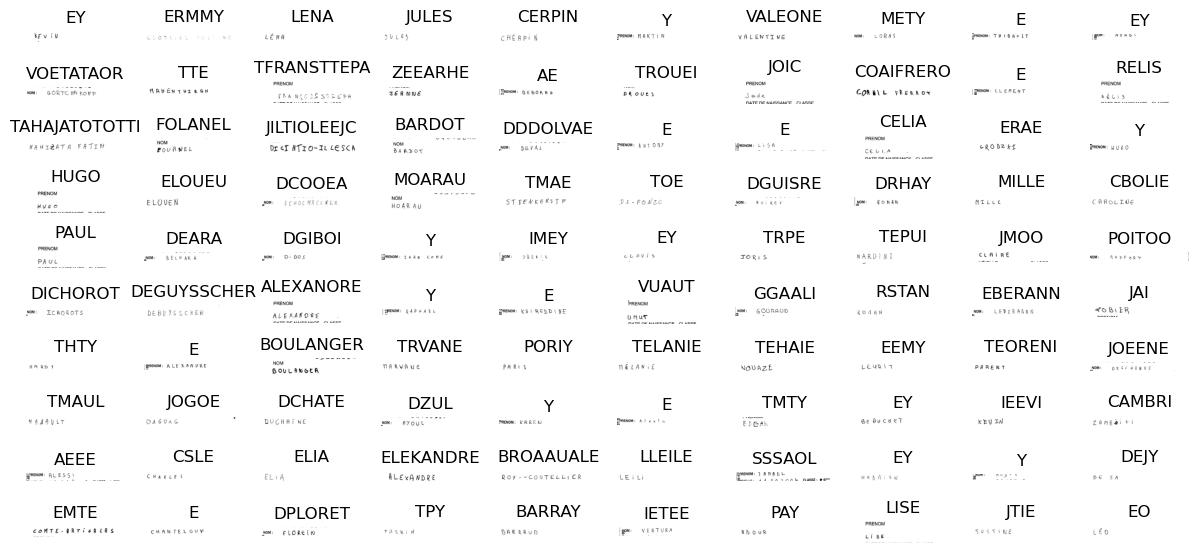

In [37]:
plt.figure(figsize=(15, 10))
for i in range(100):
    ax = plt.subplot(10, 10, i+1)
    img_dir = 'D:/WorkStation/Datasets/archive/test_v2/test/'+test_name.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [272]:

import imutils

def preprocessOutputImage(img):
    img = clipped_zoom(img, 1.3)
    (h, w) = img.shape

    # Calculate the new size while preserving the aspect ratio
    max_width = 256
    max_height = 64
    aspect_ratio = float(img.shape[1]) / img.shape[0]
    new_width = int(max_height * aspect_ratio)
    new_height = max_height

    if new_width > max_width:
        new_width = max_width
        new_height = int(new_width / aspect_ratio)

    # Ensure that the new height is at least 31 pixels
    if new_height < 31:
        new_height = 31
        new_width = int(new_height * aspect_ratio)

    # Resize the image
    if h < max_height and w < max_width:
        resized_image = img
    else:
        resized_image = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)

    # Calculate the padding values
    top = max(0, (h - new_height) // 2)
    bottom = max(0, h - new_height - top)
    left = max(0, (w - new_width) // 2)
    right = max(0, w - new_width - left)

    # Add padding if necessary
    resized_image_with_padding = resized_image
    #resized_image_with_padding = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(255, 255, 255))

    # Create a blank white image with the final size
    final_img = np.ones([64, 256])*255 

    # Resize the padded image to fit the final size
    resized_padded_image = cv2.resize(resized_image_with_padding, (256, 64), interpolation=cv2.INTER_AREA)

    # Copy the resized padded image to the final image
    final_img[:resized_padded_image.shape[0], :resized_padded_image.shape[1]] = resized_padded_image
    final_img = increaseImageQuality(final_img)
    # Rotate the final image 90 degrees clockwise
    final_img = cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)
    cv2.imwrite('test.png',final_img)
    return final_img

In [273]:
import numpy as np
from scipy.ndimage import zoom


def clipped_zoom(img, zoom_factor, **kwargs):
    
    h, w = img.shape[:2]

    # For multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    # Zooming out
    if zoom_factor < 1:

        # Bounding box of the zoomed-out image within the output array
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        # Zero-padding
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple, **kwargs)

    # Zooming in
    elif zoom_factor > 1:

        # Bounding box of the zoomed-in region within the input array
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)

        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    # If zoom_factor == 1, just return the input array
    else:
        out = img
    return out

In [274]:
def cropImage(im):
    # Get rid of existing black border by flood-filling with white from top-left corner
    ImageDraw.floodfill(im,xy=(0,0),value=(255,255,255),thresh=10)

    # Get bounding box of text and trim to it
    bbox = ImageOps.invert(im).getbbox()
    trimmed = im.crop(bbox)

    # Add new white border, then new black, then new white border
    res = ImageOps.expand(trimmed, border=10, fill=(255,255,255))
    res = ImageOps.expand(res, border=5, fill=(255,255,255))
    res = ImageOps.expand(res, border=5, fill=(255,255,255))
    res.save('result.png')
    return im

In [275]:
import cv2
import numpy as np

def increaseImageQuality(img):
    # Check image type and convert if necessary
    if img.dtype != np.uint8:
        img = np.uint8(img / np.max(img) * 255)
    # Increase the contrast of the image
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)

    # Sharpen the image
    kernel = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])
    img = cv2.filter2D(img, -1, kernel)
    
    return img


1/1 [==============================] - 0s 38ms/step


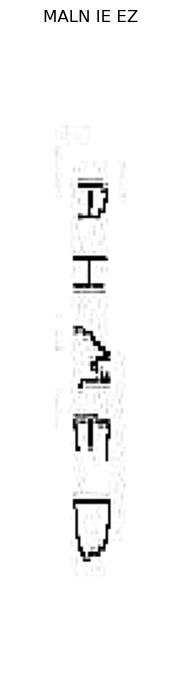

In [286]:
from PIL import Image, ImageDraw, ImageOps
plt.figure(figsize=(15, 10))
for i in range(1):
    ax = plt.subplot(2, 3, i+1)
#     img_dir = 'D:/WorkStation/Datasets/archive/test_v2/test/TEST_41355.jpg'
#     image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    #image = Image.open('D:/WorkStation/Datasets/archive/test_v2/test/TEST_41355.jpg')
    im = Image.open('D:/WorkStation/Datasets/archive/test_v2/test/TEST_41355.jpg')
    plt.imshow(image, cmap='gray')
    image = cropImage(im)
    image = cv2.imread('result.png', cv2.IMREAD_GRAYSCALE)
    image = preprocessOutputImage(image)
    image = image/255.
    plt.imshow(image, cmap='gray')
    pred = model.predict(image.reshape(1, 256, 64, 1))
    
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [220]:
model.save('new_model.h5')